# Тема роботи: **Моделювання черги у кав'ярні**

# Постановка задачі
Побудувати СМО, в якій:
1. кількість заявок на вході необмежена;
2. поява нових клієнтів відбувається з випадковим інтервалом;
3. довжина черги є обмеженою;
4. клієнти обслуговуються за правилом FIFO;
5. кількість фаз(етапів) обслуговування - 2 (касири та бариста);
6. кількість каналів на кожному етапі - 2 (два касири та два бариста);
7. час обслуговування на етапі каси та час обслуговування на етапі виконання замовлення залежить від самого замовлення та швидкості роботи працівника. 




# Теоретичні відомості
   
Предметом вивчення теорії черг (теорії масового обслуговування) є СМО. 
	
Система масового обслуговування (СМО) — система, яка здійснює обслуговування вимог, які до неї надходять.

Мета теорії масового обслуговування (теорії черг) – формування рекомендацій щодо раціональної побудови СМО, раціональної організації їх роботи та регулювання потоку заявок для забезпечення високої ефективності функціонування СМО.


###Класифікаційні ознаки систем масового обслуговування

У системах масового обслуговування розрізняють три основні етапи, які проходить кожна заявка:
поява заявки на вході до системи;
проходження черги;
процес обслуговування, після якого заявка залишає систему.
На кожному етапі використовуються певні характеристики, які слід обговорити, перш ніж будувати математичні моделі.


- Характеристики входу:
  - кількість заявок на вході (розмір популяції);
  - режим надходження заявок до системи обслуговування;
  - поведінка клієнтів.

- Характеристики черги:
  - довжина;
  - правило обслуговування. 

- Характеристики процесу обслуговування:
  - конфігурація системи обслуговування (число каналів та число фаз обслуговування);
  - режим обслуговування.


###Схема СМО
![](https://drive.google.com/uc?export=view&id=13VkdPPrutbiJ_pr5JD32g2ZtkQEDjJVY)

Поява нових клієнтів відбувається з випадковим інтервалом, отже ми будемо мати випадковий потік заявок.


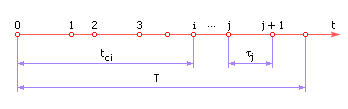

τj - інтервал між подіями (випадкова величина);

tсi - момент здійснення i-ї події (відраховується від t = 0);

T - час спостереження.

Важливою величиною є інтенсивність потоку заявок.

Інтенсивність потоку λ - це середня кількість подій за одиницю часу.

Інтенсивність потоку можна розрахувати експериментально за формулою: λ= N/Tс, де N - число подій, що відбулися за час спостереження Tс.
     Потік є стаціонарним, якщо частота появи подій λ(t) = const(t);
     За зразок потоку в моделюванні прийнято брати пуассонівський потік.
     Пуассонівський потік – це ординарний потік без післядії.
     Ймовірність того, що за інтервал часу (t0, t0 + τ) відбудеться m подій, визначається із закону Пуассона: 

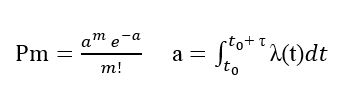

a — параметр Пуассона

Імовірність появи хоча б однієї події обчислюється наступним чином:
Px = 1 – P0 = 1 - e^(-λτ)
Для визначення інтервалу між двома випадковими подіями виражаємо τ з цієї формули :  τ = –1/λ · Ln(r)

###Оцінка ефективності роботи СМО
*   Імовірність обслуговування: Pобс. = Nобс./N

*   Пропускна спроможність системи: A = Nобс./Tс

*   Імовірність відмови: Pвідм. = Nвідм./N

*   Імовірність зайнятості одного каналу: P1 = Tзан./Tс

*   Імовірність простою обох каналів: P* = Tпрост/Tс

*   Середній час очікування заявки в черзі

*   Середній час перебування заявки у системі


#Реалізація


# Імпорт необхідних бібліотек

In [1]:

import threading
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Визначення глобальних змінних

In [2]:
flag = 0

interval_list = []
work_dict = {
'arrival_time':{},
'service_start_time':{},
'receiving_order_time':{},
'start_cooking_time':{},
'end_of_service':{},
'cashier':{},
'barista':{},
'refusal':{},
'left_the_queue':{}
}

number_of_people = 0
number_of_orders = 0
queue_pool = []
orders_pool = []

# --------------------------------------------------------------------------------------------------------------------------------------------------
drink_list = ['Espresso', 'Cappuccino', 'Latte', 'Americano', 'Moccochino', 'Cocoa', 'Cold brew', 'Black tea', 'Green tea', 'Fruit tea']
drink_probability = [0.25, 0.23, 0.17, 0.12, 0.1, 0.04, 0.005, 0.03, 0.03, 0.025]

food_list = ['Nothing', 'Cheesecake', 'Cake', 'Tiramisu', 'Donut', 'Cinnamon bun']
food_probability = [0.6, 0.2, 0.07, 0.05, 0.05, 0.03]
# --------------------------------------------------------------------------------------------------------------------------------------------------
drink_cook_time = {'Espresso': 1, 'Latte': 3, 'Americano': 1, 'Cappuccino': 3, 'Cold brew': 2,
                   'Moccochino': 3, 'Cocoa': 3, 'Black tea': 1, 'Green tea': 1, 'Fruit tea': 1}
food_cook_time = {'Tiramisu': 0.1, 'Cheesecake': 0.1, 'Cinnamon bun': 0.1, 'Cake': 0.1, 'Donut': 0.1, 'Nothing': 0}
# --------------------------------------------------------------------------------------------------------------------------------------------------
lock_a = threading.Lock()


#Визначення функцій

Функція для відліку робочого часу. Після завершення робочого часу зупиняється надходження нових заявок(клієнтів).

In [3]:
def work_time(w_time):
    time.sleep(w_time)
    global flag
    flag = 1
    print('\n////////////////////////////////////////////////////////////////////////////////////\n')
    print('Finishing work !!!')
    thread_q.join()

Функція для визначення випадкогвого інтервалу часу між надходженням двох послідовних заявок.

In [4]:
def find_interval(lambd):
    # rand - рівномірно розподілена на[0, 1] випадкова величина
    # lambd - інтенсивність Пуассонівського процесу (N / T)
    rand = np.random.sample(1)[0]
    Sk = round(-1 / lambd * np.log(rand), 3)
    interval_list.append(Sk)
    return Sk

Функція, що відповідає за надходження нової заявки в систему. Дана функція перевіряє довжину черги та додає значення в список черги (не додає у випадку, коли черга надто довга).

In [5]:
def new_client(N, T):
    global number_of_people
    global queue_pool
    global work_dict
    lambd = N / T
    dict_keys = list(work_dict.keys())[1:-2]
    time.sleep(find_interval(lambd))

    while flag == 0:
        if len(queue_pool) + len(queue_pool) <= 30:
            lock_a.acquire()
            queue_pool.append(number_of_people + 1)
            number_of_people += 1
            work_dict['refusal'][number_of_people] = False
            work_dict['left_the_queue'][number_of_people] = False
            work_dict['arrival_time'][number_of_people] = round(time.time() - start_time, 2)
            for key in dict_keys:
                work_dict[key][number_of_people] = 0
            print('-------------------------------------------------------------------------------------')
            print(round(time.time() - start_time, 2), 'New client: {}'.format(number_of_people))
            lock_a.release()
        else:
            number_of_people += 1
            work_dict['refusal'][number_of_people] = True
            work_dict['left_the_queue'][number_of_people] = False
            work_dict['arrival_time'][number_of_people] = round(time.time() - start_time, 2)
            for key in dict_keys:
                work_dict[key][number_of_people] = 0
            print('-------------------------------------------------------------------------------------')
            print('Too many people! The application was rejected!')

        time.sleep(find_interval(lambd))


Функція випадкового вибору позицій в замовленні.

In [6]:
def make_an_order():
    global number_of_orders
    drink_count = np.random.choice([1, 2, 3, 4, 5], size=1, p=[0.80, 0.1, 0.05, 0.03, 0.02])[0]
    drinks = np.random.choice(drink_list, size=drink_count, p=drink_probability)
    total_drink_cook_time = sum(drink_cook_time[el] for el in drinks)

    food = np.random.choice(food_list, size=drink_count, p=food_probability)
    total_food_cook_time = sum(food_cook_time[el] for el in food)

    new_order = {'drink': drinks, 'food': food, 'time': round(total_drink_cook_time + total_food_cook_time, 1)}
    return new_order


Функція, що моделює обслуговування клієнтів на етапі касирів. Дана функція переносить заявку із списку черги до списку замовлень для приготування.

In [7]:
def work_of_cashiers(name, work_speed):
    global flag
    global queue_pool
    global orders_pool
    global number_of_orders
    global work_dict

    # global number_of_orders
    while flag == 0 or queue_pool != []:
        lock_a.acquire()
        if queue_pool != []:
            a = queue_pool[0]
            order = {a: make_an_order()}

            queue_pool.pop(0)
            work_dict['cashier'][a] = name
            service_start_time = round(time.time() - start_time, 2)
            work_dict['service_start_time'][a] = service_start_time
            print('-------------------------------------------------------------------------------------')
            print(service_start_time, 'Cashier {} start work with client {}'.format(name, a))
            lock_a.release()
            time.sleep(1+(len(order[a]['drink']) + sum(1 for el in order[a]['food'] if el != 'Nothing'))/work_speed)
            lock_a.acquire()

            orders_pool.append(order)
            number_of_orders += 1
            receiving_order_time = round(time.time() - start_time, 2)
            work_dict['receiving_order_time'][a] = receiving_order_time
            print('-------------------------------------------------------------------------------------')
            print(receiving_order_time,
                  'Cashier {}: order {} passed to baristas'.format(name, number_of_orders))
            print('Order {} made by client № {}'.format(number_of_orders, a))
            print('Order content: \n\tDrinks: {} \n\tDesserts: {} \n\tTotal cooking time: {}'.format(", ".join(order[a]['drink']),  ", ".join(order[a]['food']),  order[a]['time']))
            lock_a.release()
            time.sleep(0.05)
        else:
            lock_a.release()


Функція, що моделює обслуговування клієнтів на етапі бариста.

In [8]:
def work_of_baristas(name, work_speed):
    global flag
    global orders_pool
    global queue_pool
    global work_dict
    while flag == 0 or queue_pool != [] or orders_pool != []:
        lock_a.acquire()
        if orders_pool != []:
            order = orders_pool[0]
            orders_pool.pop(0)
            a = list(order.keys())[0]
            work_dict['barista'][a] = name
            work_dict['start_cooking_time'][a] = round(time.time() - start_time, 2)
            b = order[a]
            lock_a.release()
            time.sleep(b['time']+len(b['drink'])/work_speed)
            end_of_service = round(time.time() - start_time, 2)
            work_dict['end_of_service'][a] = end_of_service
            print('-------------------------------------------------------------------------------------')
            print(end_of_service, 'Barista {}: order {} completed'.format(name, a))
        else:
            lock_a.release()
   

Функція, що моделює вихід із черги.

In [9]:
def leave_the_queue(r_time):
    global queue_pool
    global work_dict
    time.sleep(r_time)
    lock_a.acquire()
    if len(queue_pool) >= 2:
        a = queue_pool[-1]
        work_dict['receiving_order_time'][a] = True
        queue_pool.pop(-1)
    lock_a.release()
   

Функція, що моделює час надходження заявок до системи протягом всього часу моделювання. Повертає список, значеннями якого є час надходження кожної заявки.

In [10]:
def find_event_time(N, T):
    # rand - рівномірно розподілена на[0, 1] випадкова величина
    # lambd - інтенсивність Пуассонівського процесу (N / T)
    lambd = N / T
    rand = np.random.sample(1)[0]
    Sk = round(-1 / lambd * np.log(rand), 3)
    event_time_list = [Sk]
    while True:
        rand = np.random.sample(1)[0]
        Sk = -1 / lambd * np.log(rand)
        el = round(Sk + event_time_list[-1], 3)
        if el < T:
            event_time_list.append(el)
        else:
            break
    return event_time_list

Функція для відображення часу надходження заявок до системи.

In [11]:
def event_show(ev_time_list, T):
    ev_list_len = len(ev_time_list)
    # print(ev_list_len, ev_time_list)
    y = [0 for i in range(ev_list_len)]
    plt.figure(figsize=(10, 3))
    plt.plot([0, T], [0, 0], marker='|', color='r')
    plt.plot(ev_time_list, y, '-o', label='number of events: ' + str(ev_list_len))
    plt.title('λ = ' + str(round(N / T, 3)))
    plt.yticks([])
    plt.legend(fontsize=15)
    plt.show()

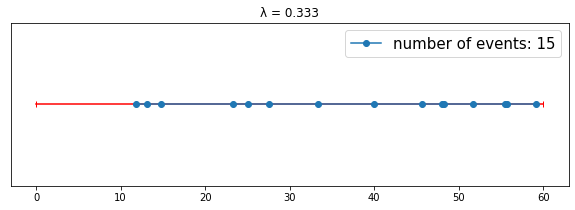

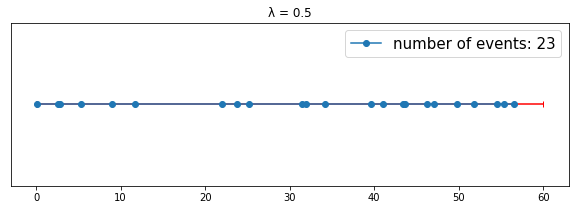

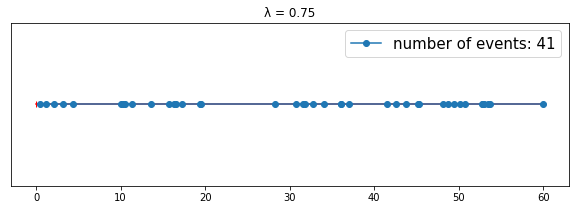

In [12]:
N, T = 20, 60
event_time_list = find_event_time(N, T)
event_show(event_time_list, T)

N, T = 30, 60
event_time_list = find_event_time(N, T)
event_show(event_time_list, T)

N, T = 45, 60
event_time_list = find_event_time(N, T)
event_show(event_time_list, T)

In [13]:
N = 30
T = 60
time_acceleration = 60


start_time = time.time()
thread_wt = threading.Thread(target=work_time, args=(T,))
thread_q = threading.Thread(target=new_client, args=(N, T))
thread_leave_q = threading.Thread(target=leave_the_queue, args=(np.random.uniform(10, T), ))

thread_k1 = threading.Thread(target=work_of_cashiers, args=("K1", 0.4*time_acceleration))
thread_k2 = threading.Thread(target=work_of_cashiers, args=("K2", 0.2*time_acceleration))
thread_b1 = threading.Thread(target=work_of_baristas, args=("B1", 0.2*time_acceleration))
thread_b2 = threading.Thread(target=work_of_baristas, args=("B2", 0.2*time_acceleration))

thread_wt.start()
thread_q.start()
thread_leave_q.start()

thread_k1.start()
thread_k2.start()
thread_b1.start()
thread_b2.start()
print('-------------------------------------------------------------------------------------')
thread_k1.join()
thread_k2.join()
thread_b1.join()
thread_b2.join()
thread_wt.join()

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
0.87 New client: 1
-------------------------------------------------------------------------------------
0.87 Cashier K1 start work with client 1
-------------------------------------------------------------------------------------
1.92 Cashier K1: order 1 passed to baristas
Order 1 made by client № 1
Order content: 
	Drinks: Espresso 
	Desserts: Nothing 
	Total cooking time: 1
-------------------------------------------------------------------------------------
2.16 New client: 2
-------------------------------------------------------------------------------------
2.16 Cashier K2 start work with client 2
-------------------------------------------------------------------------------------
2.41 New client: 3
-------------------------------------------------------------------------------------
2.41 Cashier K1 start wo

In [14]:
df0 = pd.DataFrame(work_dict)
df0.to_csv(str(N)+'_'+str(T)+'out.csv')
df = df0[(df0.refusal == False) & (df0.left_the_queue == False)]
df1 = pd.DataFrame()

arr = np.array([df['service_start_time'].to_list(), df['receiving_order_time'].to_list()]).transpose()

arr_len = len(arr)
res = []
for i in range(arr_len-1):
    first = arr[i]
    second = arr[i+1]
    if first[0] > second[0]:
        res.append([second[1], first[0]])
    elif first[1] < second[0]:
        res.append([first[1], second[0]])

# час простою обох касирів
downtime2 = sum(el[1]-el[0] for el in res)

res = []
for i in range(arr_len-1):
    first = arr[i]
    second = arr[i+1]
    if first[0] <= second[1] and first[1] >= second[0]:
        res.append([second[0], first[1]])

# час роботи обох касирів
w_time2 = sum(el[1]-el[0] for el in res)


df1['time_in_queue'] = df['service_start_time'] - df['arrival_time']
df1['service_time'] = df['end_of_service'] - df['arrival_time']


#Відображення результатів

In [15]:

df0.head(10)

,arrival_time,service_start_time,receiving_order_time,start_cooking_time,end_of_service,cashier,barista,refusal,left_the_queue
1,0.87,0.87,1.92,1.92,3.01,K1,B2,False,False
2,2.16,2.16,3.25,3.25,6.34,K2,B1,False,False
3,2.41,2.41,3.46,3.46,6.54,K1,B2,False,False
4,4.97,4.97,6.06,6.35,7.53,K1,B1,False,False
5,7.84,7.84,8.88,8.88,9.97,K1,B2,False,False
6,8.63,8.63,10.05,10.05,19.51,K2,B2,False,False
7,9.31,9.31,10.35,10.36,13.44,K1,B1,False,False
8,10.36,10.37,11.53,13.44,16.64,K2,B1,False,False
9,10.66,10.66,11.71,16.64,19.72,K1,B1,False,False
10,15.75,15.75,16.92,19.51,22.70,K2,B2,False,False


In [16]:

print('\n-------------------------------------------------------------------------------------')
print(df1.describe())
print('\n-------------------------------------------------------------------------------------')
print('Probability of service:', round(number_of_orders / number_of_people * 100, 2), '%')
print('System bandwidth:', round(number_of_orders / T, 2))
print('Probability of failure:', round((number_of_people - number_of_orders) / number_of_people * 100, 2), '%')
print('Probability of employment of one channel:', round((T - downtime2 - w_time2) / T * 100, 2), '%')
print('Probability of downtime of both channels:', round(downtime2 / T * 100, 2), '%')
print('Average waiting time for the application in the queue:', round(df1['time_in_queue'].mean(), 2))
print('Average time spent in the system:', round(df1['service_time'].mean(), 2))
print('-------------------------------------------------------------------------------------')


-------------------------------------------------------------------------------------
       time_in_queue  service_time
count      30.000000      30.00000
mean        0.020333       4.75200
std         0.070880       2.62865
min         0.000000       2.13000
25%         0.000000       2.30500
50%         0.000000       4.23500
75%         0.000000       6.12500
max         0.300000      10.88000

-------------------------------------------------------------------------------------
Probability of service: 100.0 %
System bandwidth: 0.5
Probability of failure: 0.0 %
Probability of employment of one channel: 41.35 %
Probability of downtime of both channels: 46.02 %
Average waiting time for the application in the queue: 0.02
Average time spent in the system: 4.75
-------------------------------------------------------------------------------------


#Висновки

В ході даної роботи було досліджено було досліджено математичне моделювання черг на прикладі моделювання черги в кав'ярні. Для даної моделі основними параметрами виявилися кількість каналів на кожному етапі обслуговування та кількість заявок, які надходять до системи за певний проміжок часу. Змоделювавши роботу кав'ярні з двома касирами, двома бариста при інтенсивності надходження заявок 30 клієнтів за годину, можна побачити, що час очікування в черзі дуже малий порівняно з часом очікування замовлення. Такий результат цілком очікуваний, адже касирам на отримання замовлення необхідно значно менше часу ніж баристам на його приготування. Дану проблему можна вирішити, збільшивши кількість кавоварок, що значно підвищить швидкість роботи бариста.  
